In [1]:
#Notebooks for small tests
import os  
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
#imports and plotting function
import argparse
import mat73
import logging
import numpy as np
#import torchvision
from datetime import datetime
import os
import scipy.io
from torch.utils.data import DataLoader
import io
from PIL import Image
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import wandb
import math
import torch.nn.functional as F
import torchvision.transforms as T
import torch.nn as nn
import torch
import sys
import torch.optim.lr_scheduler as lr_scheduler
import wandb
import torch
from sklearn.preprocessing import StandardScaler
import Models as M
import Helpers as H
import time
from torch.func import vmap
from functorch.experimental import replace_all_batch_norm_modules_
%matplotlib inline

encoder_out='sigmoid'
cwd=os. getcwd()

data_path=os.path.join(cwd,'PNAS-regime_all_seeds/PNAS-regime_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)
#b=np.load(data_path+'/train/b.npy')
#rho=np.load(data_path+'/train/rho.npy')
#print(np.allclose(medium@rho[0],b[0]))


(1450, 400)
(400, 400)
coherence of data:  0.7119395644427655


Medium: (1450, 400), Rho: (2000, 400), B: (2000, 1450)


Medium: (1450, 400), Rho: (3000, 400), B: (3000, 1450)
8281000
Data shapes: 1450.0 200.0


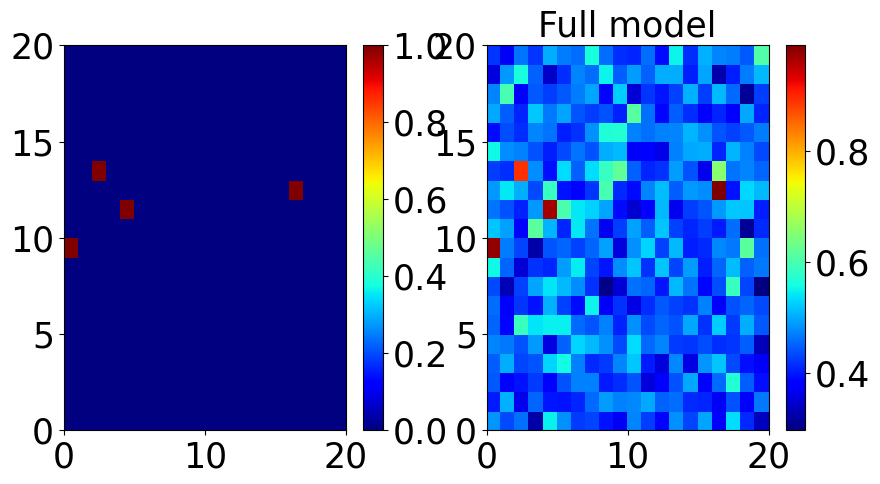

time for labeled: 13.193795680999756


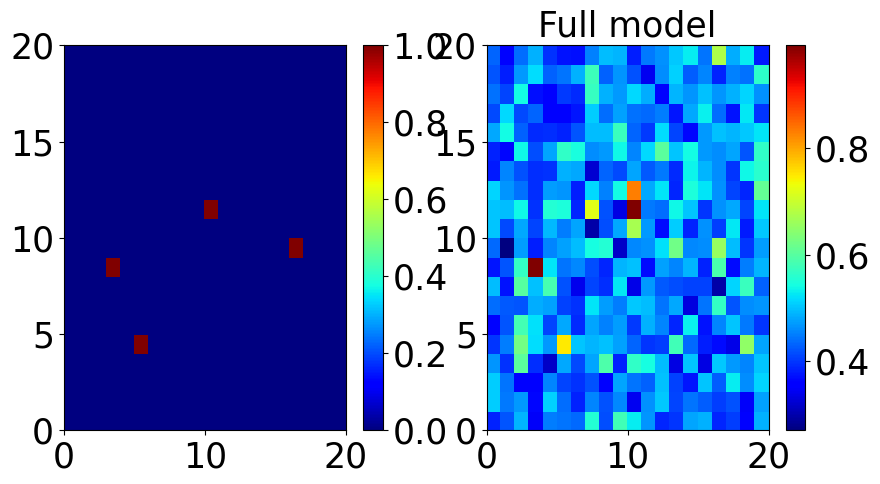

In [4]:
#Raw data training
starttime=time.time()
target='raw'
labeled_data=2000
layer_loss_list=[]
Epochs=10
Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
batchsize=128
layers=[500,500, 500, 300, 300, 400,800]
training_data=H.data_rho_loaded(data_path+'/train',labeled_data/80000)
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=4)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
valloader=DataLoader(val_data,batch_size=512,shuffle=True,num_workers=4)
encoder=M.fc_net_extra(training_data.b[0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)


relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.BCELoss()   
L2_loss_fn=nn.MSELoss()
for epoch in range(Epochs):
    train_lossavg=0
    train_lossavg=0
    encoder.train()
    for batch, (b,rho,num_targets) in enumerate(trainloader):
        optimizer.zero_grad()

        b=b.to(device)
        rho=rho.to(device)    
        if labeled_data==1:
            b=b.squeeze().unsqueeze(0).repeat(128,1).unsqueeze(1)  
            rho=rho.squeeze().unsqueeze(0).repeat(128,1).unsqueeze(1)
        font_size = 50
        rho_hat=encoder(b)
        rh, _=torch.split(rho, 400, dim=-1)
        if encoder_out=='sigmoid':
            #rho_hat=rho_hat-rho
            rho_hat=sigmoid(rho_hat)
        elif encoder_out=='softmax':
            rho_hat=5*softmax(rho_hat.squeeze())
        elif encoder_out=='relu':
            rho_hat=relu(rho_hat.squeeze())
        #rho_hat=relu(rho_hat.squeeze())
        #H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5)    
        if encoder_out=='sigmoid' or encoder_out=='softmax':
            #print(rho_hat.shape, rh.shape)
            bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
            bce_loss.backward() 
            train_lossavg+=bce_loss.item()/len(trainloader)

        else:
            L2_loss=L2_loss_fn(rho_hat.squeeze(), rh.squeeze())    
            L2_loss.backward()
            train_lossavg+=L2_loss.item()/len(trainloader)
        optimizer.step()
    if epoch==Epochs-1:
        H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
        finish=time.time()-starttime
        print(f"time for labeled: {finish}")
    wand_dict['train loss']=train_lossavg
    val_loss=0
    encoder.eval()
    for batch, (b,rho,num_targets) in enumerate(valloader):
        b=b.to(device)
        rho=rho.to(device)    
        font_size = 50
        rho_hat=encoder(b)
        if encoder_out=='sigmoid':
            rho_hat=sigmoid(rho_hat)
        elif encoder_out=='softmax':
            rho_hat=5*softmax(rho_hat.squeeze())
        elif encoder_out=='relu':
            rho_hat=relu(rho_hat.squeeze())
        #rho_hat=relu(rho_hat.squeeze())
        #H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5)    
        rh, _=torch.split(rho, 400, dim=-1)
        if encoder_out=='sigmoid' or encoder_out=='softmax':

            bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
            val_loss+=bce_loss.item()/len(valloader)
        else:
            L2_loss=L2_loss_fn(rho_hat.squeeze(), rh.squeeze())    
            val_loss+=L2_loss.item()/len(valloader)
    wand_dict['val loss']=val_loss
    if epoch==Epochs-1:
       H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    if Track_run:
        wandb.log(wand_dict)

if Track_run:
    wandb.finish()


In [5]:
#cc data training
starttime=time.time()
target='raw'
labeled_data=400
layer_loss_list=[]
Epochs=40
Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
batchsize=400
layers=[250,1000,750,500, 500, 300, 300, 400,800]
training_data=H.data_rho_CC(data_path+'/train',labeled_data/80000,1)
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=4)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
val_data=H.data_rho_CC(data_path+'/val', 3000/80000,1)
valloader=DataLoader(val_data,batch_size=batchsize,shuffle=True,num_workers=4)
encoder=M.fc_net_extra(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)


relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.CrossEntropyLoss()   
L2_loss_fn=nn.MSELoss()
for epoch in range(Epochs):
    train_lossavg=0
    train_lossavg=0
    encoder.train()
    for batch, (b,rho,num_targets) in enumerate(trainloader):
        optimizer.zero_grad()

        b=b.to(device)
        rho=rho.to(device)    
        rho_hat=encoder(b)
        rh, _=torch.split(rho, 400, dim=-1)
        bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
        bce_loss.backward() 
        train_lossavg+=bce_loss.item()/len(trainloader)
        optimizer.step()
    if epoch==Epochs-1:
        H.plot_2_imgs(rho, softmax(rho_hat),ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
        finish=time.time()-starttime
        print(f"time for labeled: {finish}")
    print(f'epoch: {epoch}, train loss: {train_lossavg}')
val_loss=0
encoder.eval()
for batch, (b,rho,num_targets) in enumerate(valloader):
    b=b.to(device)
    rho=rho.to(device)    
    font_size = 50
    rho_hat=encoder(b)
    rh, _=torch.split(rho, 400, dim=-1)
    bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
    val_loss+=bce_loss.item()/len(valloader)
    if batch==0:
        H.plot_2_imgs(rho, softmax(rho_hat),ind=5, figsize=5, xpix=20, ypix=20, font_size=25)

wand_dict['val loss']=val_loss
print(f'val loss: {val_loss}')
if Track_run:
    wandb.log(wand_dict)


Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
Medium: (1450, 400), Rho: (3000, 400), B: (3000, 1450)
Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
22014000
Data shapes: 725.0 200.0
epoch: 0, train loss: 6.430170059204102
epoch: 1, train loss: 6.474627494812012
epoch: 2, train loss: 5.557901382446289
epoch: 3, train loss: 4.253535270690918
epoch: 4, train loss: 3.2203052043914795
epoch: 5, train loss: 2.693877696990967
epoch: 6, train loss: 2.3260281085968018
epoch: 7, train loss: 2.0498921871185303
epoch: 8, train loss: 1.8352532386779785
epoch: 9, train loss: 1.6638774871826172
epoch: 10, train loss: 1.5179468393325806
epoch: 11, train loss: 1.3991161584854126
epoch: 12, train loss: 1.3391550779342651
epoch: 13, train loss: 1.4191172122955322
epoch: 14, train loss: 1.433652639389038
epoch: 15, train loss: 1.2017053365707397


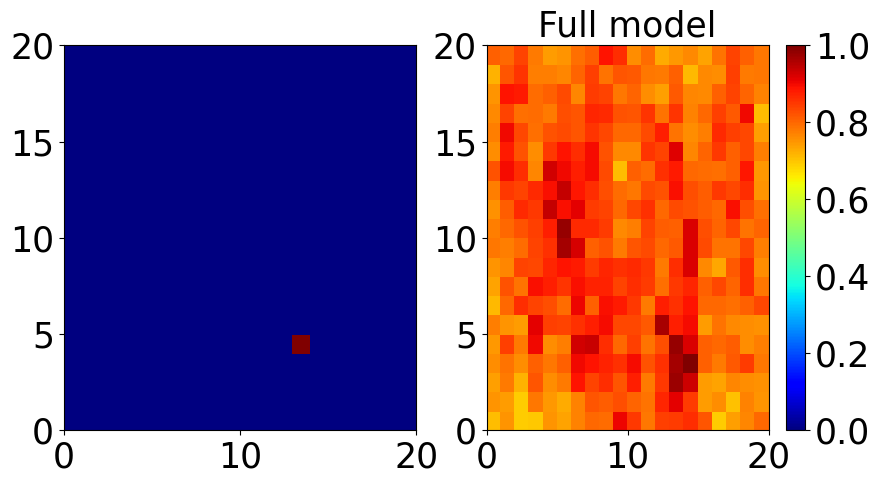

In [4]:
H.plot_2_imgs(rho, softmax(rho_hat),ind=5, figsize=5, xpix=20, ypix=20, font_size=25)


In [ ]:
#loads model from location and gets Ghat error
data_path='/home/achristie/Codes_data/PNAS-regime_all_seeds/PNAS-regime_seed0'
location='/home/achristie/Codes_data/Experiment_data/Complex_tests/0L_320000U_[500, 500, 500, 300, 300, 400, 800]_06-May-2024 (14:12:11)decoder.pt'
decoder=nn.Linear(400, 1450*2, bias=False)
decoder.load_state_dict(torch.load(location))
Complex_eye=torch.eye(400).unsqueeze(1)
medium_hat=decoder(Complex_eye).squeeze()
medium_hat=F.normalize(medium_hat, dim=-1)
medium_hat=medium_hat.cpu().detach().numpy()
medium_hat=H.cat2complex(medium_hat)
torch_inners=np.abs(np.inner(medium_hat,medium.T.conj(), ).diagonal())
mean_inn_product=np.mean(torch_inners)
print(mean_inn_product)


0.1661837688155095


In [ ]:
layers=[500,500, 500, 300, 300, 400,800]
softmax=nn.Softmax(dim=1)
Orderer=M.fc_net_extra(training_data.b[0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
locat="/home/achristie/Codes_data/Experiment_data/hom/5000L_0U_[500, 500, 500, 300, 300, 400, 800]_13-May-2024 (13:14:58)"
Orderer.load_state_dict(torch.load(locat+'encoder.pt'))
decoder_locat="/home/achristie/Codes_data/Experiment_data/Long_best_exps/0L_320000U_[500, 500, 500, 300, 300, 400, 800]_12-May-2024 (11:03:02)decoder.pt"
Orderer.eval()
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
decoder=nn.Linear(400, 1450*2, bias=False)
decoder.load_state_dict(torch.load(decoder_locat))
decoder_weights=decoder.weight.cpu().detach().numpy().T
decoder_weights=torch.tensor(decoder_weights)
decoder_weights=F.normalize(decoder_weights, dim=-1)
perm=Orderer(decoder_weights)

#gotta confirm outscaling is the same
perm=(softmax(perm))
largest,indices=torch.max(perm, -1)
perm_mat=torch.zeros(perm.shape)
for i in range(len(perm)):
    perm_mat[i, indices[i]]=1

perm_mat=perm_mat.cpu().detach().numpy()
medium_hat=H.cat2complex(decoder_weights.cpu().detach().numpy())
medium_hat_permed=(medium_hat.T@np.linalge.inv(perm_mat)).T
medium_hat_permed=F.normalize(torch.tensor(medium_hat_permed), dim=-1).numpy()
#medium_hat_inverse_permed=(medium_hat.T@np.linalg.inv(perm_mat.T)).T



max_inners_1=0
torch_inners=np.abs(np.inner(medium_hat_permed.squeeze(),medium.T.conj()))
for i in range(int(200*2)):
    max_inners_1=max_inners_1+max(torch_inners[:,i]) #Fix g, find max over ghat

max_inners_1=max_inners_1/(int(200*2))


print(max_inners_1)


0.6716700740174152


In [3]:
b=np.array(mat73.loadmat(data_path+'/raw_train.mat')['b_d_train'])
rho=np.array(mat73.loadmat(data_path+'/rho_train.mat')['rho_d_train'])
cc=np.array(mat73.loadmat(data_path+'/cc_train.mat')['cc_d_train'])
Mask=np.array(mat73.loadmat(data_path+'/M.mat')['M'])

outer=np.outer(b,b.conj())
outer=outer[abs(Mask)>0]
outer=outer.ravel()



        #self.Mask=np.array(mat73.loadmat(data_path+'/M.mat')['M'])


In [5]:
np.sort(outer[0].real, cc

((0.0050157915875806425+0j), (0.0007125699727423029-0.0022415345257136435j))

In [9]:
outer.shape, cc.shape

((12124,), (12124,))

In [4]:
np.allclose(outer,cc)

True

(2900, 2900)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 2900 but corresponding boolean dimension is 1450

In [20]:
class data_rho_CC:
    def __init__(self,data_path ,prop,sparsity=4):
        if 'PNAS' in data_path and "train" in data_path:
            self.rho, self.b=H.Generate_data_pnas(data_path[:-5],int(80000*prop), S=sparsity,seed=0)
            self.data_path=data_path[:-5]

        elif 'PNAS' in data_path and 'val' in data_path:
            self.rho, self.b=H.Generate_data_pnas(data_path[:-3],3000, S=sparsity,seed=100)
            self.data_path=data_path[:-3]
        self.Mask=np.array(mat73.loadmat(self.data_path+'/M.mat')['M'])
        
    def __len__(self):
        return(int(len(self.b)))

    def __getitem__(self, idx):
        outer=np.outer(self.b[idx,...],self.b[idx,...].conj())
        outer=outer[abs(self.Mask)>0]
        outer=outer.ravel()

        return torch.cat((torch.tensor(outer.real),torch.tensor(outer.imag)),dim=-1).float(),self.rho[idx,...].float(), float(torch.sum(self.rho[idx,...].real))
        
training_data[0]


Medium: (1450, 400), Rho: (50000, 400), B: (50000, 1450)


In [23]:
training_data[0].shape

AttributeError: 'NoneType' object has no attribute 'shape'

In [14]:
training_data=H.data_rho_CC(data_path+'/train',500/80000,1)
b=np.array(mat73.loadmat(data_path+'/raw_train.mat')['b_d_train'])
rho=np.array(mat73.loadmat(data_path+'/rho_train.mat')['rho_d_train'])
cc=np.array(mat73.loadmat(data_path+'/cc_train.mat')['cc_d_train'])
Mask=np.array(mat73.loadmat(data_path+'/M.mat')['M'])
b=training_data.b[0]
outer=np.outer(b,b.conj())
outer=outer[abs(Mask)>0]
outer=outer.ravel()
outer[5],training_data[0][0][5].numpy().item()


Medium: (1450, 400), Rho: (500, 400), B: (500, 1450)


((0.000689655172413793+0j), 0.0006896551931276917)